# 99 - Fermionic QAOA (FQAOA)

This notebook provides a brief introduction to Fermionic QAOA (FQAOA) and shows how this technique is implemented in the OpenQAOA workflow by solving the [portfolio optimization](https://en.wikipedia.org/wiki/Portfolio_optimization) problem, an NP-hard problem.
Details in the conventional QAOAs can be found in [1]. 

## A brief introduction

We present an implementation of a novel algorithm designed for solving combinatorial optimization problems with constraints, utilizing the principles of quantum computing. The algorithm, known as the FQAOA [2, 3], introduces a significant enhancement over traditional methods by leveraging fermion particle number preservation. This intrinsic property allows the algorithm to enforce constraints naturally throughout the optimization process, addressing a critical challenge in many combinatorial problems.

### Key Features
- Constraint Handling: Unlike conventional approaches where constraints are treated as soft constraints in the cost function, FQAOA intrinsically enforces constraints by preserving fermion particle number, thus improving the overall performance of the optimization algorithm.

- Mixer Hamiltonian Design: The algorithm provides a systematic guideline for designing the mixer Hamiltonian tailored to a given problem Hamiltonian with constraints. This ensures that the initial state can be a superposition of states that satisfy the constraint and the ground state of the mixer Hamiltonian.

- Adiabatic Evolution: FQAOA effectively reduces to quantum adiabatic computation in the large limit of circuit depth, $p$, offering improved performance even for shallow circuits by optimizing parameters starting from fixed angles determined by Trotterized quantum adiabatic evolution.

- Performance Advantage: Extensive numerical simulations demonstrate that FQAOA offers substantial performance benefits over existing methods, particularly in portfolio optimization problems.

- Broad Applicability: The Hamiltonian design guideline is not only beneficial for QAOA but also extends to other algorithms like Grover adaptive search and quantum phase estimation, making it a versatile tool for solving constrained combinatorial optimization problems.

This notebook will guide you through the implementation of FQAOA, illustrating its application through various examples and providing insights into its superior performance in constrained combinatorial optimization tasks.

### Constrained Combinatorial Optimization Problems and Cost Hamiltonian
The constrained combinatorial optimization problem for a polynomial cost function　$C_{\boldsymbol x}$ covered here can be written in the following form：
$${\boldsymbol x}^* = \arg \min_{\boldsymbol x} C_{\boldsymbol x}\qquad {\rm s.t.} \quad\sum_{i=1}^{N} x_i = M,$$
with bit string ${\boldsymbol x}\in \{0,1\}^N$, where ${\boldsymbol x}^*$ is the optimal solution.
This problem can be replaced by the minimum eigenvalue problem in the following steps.

1. map the cost function $C_{\boldsymbol x}$ to the cost Hamiltonian $\hat{\cal H}_C$ by $x_i\rightarrow \hat{n}_i$:
\begin{eqnarray}
C_{\boldsymbol x} &=& \sum_i I_i x_{i}+\sum_{i_1,i_2} I_{i_1,i_2} x_{i_1}x_{i_2}+\cdots +
\sum_{i_1,i_2,\cdots i_K} I_{i_1,i_2,\cdots i_K} x_{i_1}x_{i_2}\cdots x_{i_K}\\
&\mapsto&\hat{\cal H}_C=\sum_i I_i \hat{n}_{i}+\sum_{i_1,i_2} I_{i_1,i_2} \hat{n}_{i_1}\hat{n}_{i_2}+\cdots +
\sum_{i_1,i_2,\cdots i_K} I_{i_1,i_2,\cdots i_K} \hat{n}_{i_1}\hat{n}_{i_2}\cdots \hat{n}_{i_K},
\end{eqnarray}
where $\hat{n}_i = \hat{c}^\dagger_i\hat{c}_i$ is number operator and $\hat{c}_i^\dagger (\hat{c}_i)$ is creation (annihilation) operator of fermion at $i$-th site.

2. formulate eigen value problems for combinatorial optimization problem under the constraint:
\begin{eqnarray}
\hat{\cal H}_C|x_1x_2\cdots x_N\rangle &=& C_{\boldsymbol x}|x_1x_2\cdots x_N\rangle,\\
\sum_{i=1}^{N} \hat{n}_i|x_1x_2\cdots x_N\rangle &=& M|x_1x_2\cdots x_N\rangle,
\end{eqnarray}
where $|x_1x_2\cdots x_N\rangle=(\hat{c}^\dagger_1)^{x_1}(\hat{c}^\dagger_2)^{x_2}\cdots (\hat{c}^\dagger_N)^{x_N}|{\rm vac}\rangle$ is fermionic basis state and $|\rm vac\rangle$ is vacuum satisfying $\hat{c}_i|\rm vac\rangle=0$.

3. optimize FQAOA ansatz:
$$|\psi_p({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)\rangle 
= \left[\prod_{j=1}^pU(\hat{\cal H}^\alpha_M,\beta_j^*){U}(\hat{\cal H}_C,\gamma_j^*)\right]\hat{U}^\alpha_{\rm init}|{\rm vac}\rangle
\qquad {\rm by}\quad
C_p({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)=\min_{{\boldsymbol \gamma}, {\boldsymbol \beta}}C_p({\boldsymbol \gamma},{\boldsymbol \beta}),$$
$$\qquad{\rm where \quad}C_p({\boldsymbol \gamma}, {\boldsymbol \beta}) = \langle\psi_p({\boldsymbol \gamma}, {\boldsymbol \beta})|\hat{\cal H}_C|\psi_p({\boldsymbol \gamma}, {\boldsymbol \beta})\rangle.$$
The variational parameters $({\boldsymbol \gamma}^*, {\boldsymbol \beta}^*)$ give the lowest cost value at QAOA level $p$.


### One-Dimensional Mixer Hamiltonian

The FQAOA implemented on OpenQAOA employs mixer Hamiltonians on one-dimensional lattices. The main features of this computational model are summarized based on the study [3]:

- Utilises a mixer Hamiltonian on a one-dimensional lattice dedicated to combinatorial optimization problems with equality constraints of the same coefficients.

- Reduced Gate Operations: The new mixer Hamiltonian significantly reduces the number of gate operations in quantum circuits compared to previous studies [2], thus improving computational efficiency.

- Noise suppression: as demonstrated in a 16-qubit trapped-ion quantum computer on Amazon Braket, the proposed mixer Hamiltonian effectively suppresses noise and improves algorithm performance.

As these features enhance the performance and reliability of FQAOA for solving constrained combinatorial optimization problems, we focus on FQAOA with one-dimensional mixer hamiltonians.

The specific mixer hamiltonians　$\hat{\cal H}_M^\alpha$ on chain lattice ($\alpha$=chn) and cyclic lattice ($\alpha$=cyc) to be implemented in OpenQAOA are as follow:

\begin{eqnarray}
\hat{\cal H}^{\rm chn}_M &=& t\sum_{i=1}^{N-1} (\hat{c}^\dagger_i\hat{c}_{i+1}+\hat{c}^\dagger_{i+1}\hat{c}_i),\\
\hat{\cal H}^{\rm cyc}_M &=& t\sum_{i=1}^{N-1} (\hat{c}^\dagger_i\hat{c}_{i+1}+\hat{c}^\dagger_{i+1}\hat{c}_i)-t(-1)^{M}(\hat{c}^\dagger_N\hat{c}_{1}+\hat{c}^\dagger_{1}\hat{c}_N).
\end{eqnarray}
These Hamiltonians can be diagonalized as:
$$\hat{\cal H}_M^{\alpha}=\sum_{i=1}^{N}\varepsilon^{\alpha}_i\hat{\gamma}_i^\dagger\hat{\gamma}_i \qquad {\rm with} \quad
\hat{\gamma}_i^\dagger = \sum_{j=1}^N[\phi_0^{\alpha}]_{i,j}\hat{c}^\dagger_j,$$
where $[\phi_0^{\alpha}]$ is the unitary matrix used for the diagonalization and $\varepsilon^\alpha_i$ is eigenvalue.
The formulation and validation of the model on cyclic lattice ($\alpha$=cyc) are detailed in the study [2].

### Initial States and Mixers for FQAOA

The initial state preparation unitary $\hat{U}_{\rm init}$ and mixer $\hat{U}_M$ used to implement the FQAOA are described.

We describe the specific mixer Hamiltonians $\hat{\cal H}_M^\alpha$ on chain lattice ($\alpha$=chn) and cyclic lattice ($\alpha$=cyc) utilized for our implementation of the FQAOA. 

We describe the specific calculation model utilized for our implementation of the FQAOA on chain and cyclic lattices. The formulation and validation of the model on cyclic lattice are detailed in the study [2].

- initial state preparation unitary $\hat{U}^{\alpha}_{\rm init}$ on chain lattice ($\alpha$=chn) and cyclic lattice ($\alpha$=cyc):
$$|\phi^\alpha_0\rangle=\hat{U}^\alpha_{\rm init}|{\rm vac}\rangle=\left(\prod_{i=1}^{M}\hat{\gamma}_i^\dagger\right)|{\rm vac}\rangle,
\qquad{\rm with}\quad \hat{U}^{\alpha}_{\rm init}=\prod_{i=1}^{M}\left(\sum_{j=1}^N[\phi_0^{\alpha}]_{i,j}\hat{c}^\dagger_j\right),$$
where $M$ is the number of fermions and $i$ indexes the eigenvalues $\varepsilon^\alpha_i$ in ascending order.
The implementation of the initial state preparation unitary on quantum circuit are shown in Refs. [2-4].

- mixing unitary $U(\hat{\cal H}^\alpha_M, \beta)$ on chain lattice ($\alpha$=chn) and cyclic lattice ($\alpha$=cyc):
\begin{eqnarray}
U(\hat{\cal H}^{\rm chn}_M, \beta) &\sim& \exp\left[-i\beta t\left(\hat{c}^{\dagger}_{N-1}\hat{c}_N+\hat{c}^{\dagger}_N\hat{c}_{N-1}\right)\right]\cdots
\exp\left[-i\beta t\left(\hat{c}^{\dagger}_2\hat{c}_3+\hat{c}^{\dagger}_3\hat{c}_2\right)\right]
\exp\left[-i\beta t\left(\hat{c}^{\dagger}_1\hat{c}_2+\hat{c}^{\dagger}_2\hat{c}_1\right)\right],\\
U(\hat{\cal H}^{\rm cyc}_M, \beta) &\sim&
\exp\left[i\beta t(-1)^M\left(\hat{c}^{\dagger}_{ND}\hat{c}_{1}+\hat{c}^{\dagger}_{1}\hat{c}_{ND}\right)\right]
\prod_{i\ {\rm even}}\exp\left[-i\beta t\left(\hat{c}^{\dagger}_i\hat{c}_{i+1}+\hat{c}^{\dagger}_{i+1}\hat{c}_{i}\right)\right]
\prod_{i\ {\rm odd}}\exp\left[-i\beta t\left(\hat{c}^{\dagger}_i\hat{c}_{i+1}+\hat{c}^{\dagger}_{i+1}\hat{c}_{i}\right)\right],
\end{eqnarray}
where the approximation by Trotter decomposition is applied, as certain hopping terms are non-commutative.
The implementation of the mixed unitary indicated on the right-hand side on quantum circuits is given in Refs. [2, 3, 5, 6].

## Problem: Portfolio Optimization

In [2]:
%matplotlib notebook

# Import external libraries to present an manipulate the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import docplex model to generate the problem to optimize
from docplex.mp.model import Model

# Import the libraries needed to employ the QAOA quantum algorithm using OpenQAOA
from openqaoa import QAOA

# method to covnert a docplex model to a qubo problem
from openqaoa.problems.converters import FromDocplex2IsingModel
from openqaoa.backends import create_device

# method to find the corrects states for the QAOA boject 
from openqaoa.utilities import ground_state_hamiltonian

# method to generate the circuit for initial state preperation in the FQAOA
from fqaoa_initial import InitialStatePreparation

The objective function of the portfolio optimization problem is given by 

$$\max_{x} : \mu^{T} x-q x^{T} \Sigma x,\qquad {\rm s.t.} \quad\sum_{i=1}^{N} x_i = B,$$

where:
- $N$ represents the number of assets
- $x \in\{0,1\}^{N}$ denotes the vector of binary decision variables, which indicate which assets to pick ( $\left.x[i]=1\right)$ and which not to pick $(x[i]=0)$,
- $\mu \in R^{n}$ defines the expected returns for the assets,
- $\Sigma \in R^{n \times n}$ specifies the covariances between the assets,
- $q>0$ controls the risk aversion of the decision maker,
- $B$ denotes the budget, i.e., the total investment..

To simplify the problem, it is used a random function to generate the predictions the expected return for 10 assets during 15 days.

In [2]:
# For the case of reproducibility this seed is configured
np.random.seed(1)

# Init variables to geretate the data
# consider the number of the assets and the numbero f days 
num_assets = 10
num_days = 15

# Risk aversion
q = 0.01 

# The limit of the budget, is consider as constraint
Budget = 5

# Cost of buying the different assets c_i
c = num_assets * [1] 
# Creating a random history of the forcasting for the expected return 
hist_exp = (1 - 2 * np.random.rand(num_assets)).reshape(-1,1) * (np.array([np.arange(num_days) for i in range(num_assets)]) + np.random.randint(10)) + (1 - 2 * np.random.rand(num_assets,  num_days)) 

# Mean expected return over the  num_days value
mu = hist_exp.mean(axis=1)
# Covariance matrix (Sigma) for the risk term of the cost function
sigma = np.cov(hist_exp) 

Text(0.5, 1.0, 'Covariance Matrix $\\Sigma$ associated to the risk')

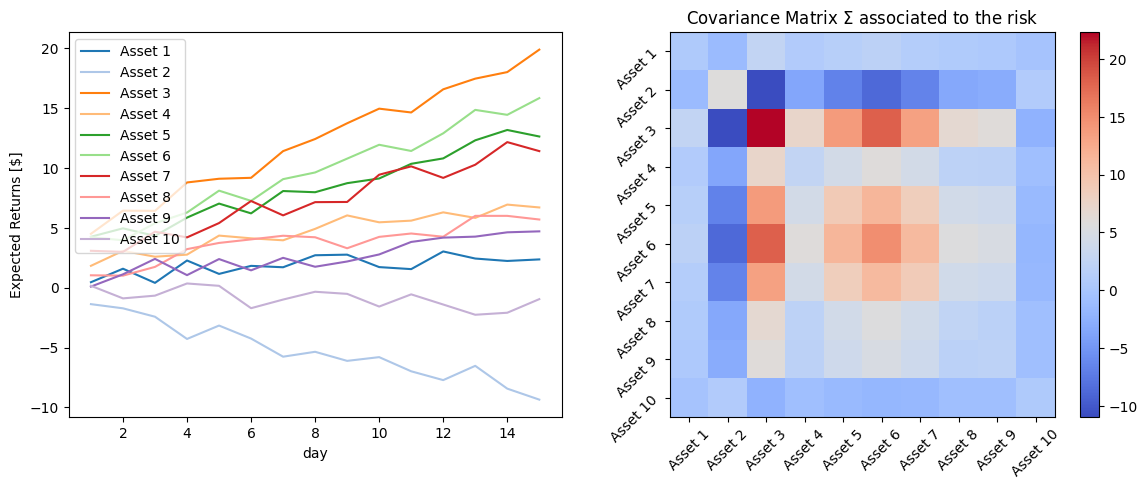

In [3]:
%matplotlib inline

# Plot the stock's time series
fig, ax = plt.subplots(1, 2, figsize=(14,5))
colors = plt.cm.tab20(range(20))
for i in range(num_assets):
    ax[0].plot(range(1, num_days+1), hist_exp[i], color=colors[i])
ax[0].set_xlabel("day")
ax[0].set_ylabel("Expected Returns [$]")
ax[0].legend([f"Asset {i}" for i in range(1, num_assets+1)])
im = ax[1].imshow(sigma, cmap="coolwarm")
fig.colorbar(im)

# Plot the covariance matrix
ax[1].set_yticks(range(num_assets))
ax[1].set_xticks(range(num_assets))
ax[1].set_xticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_yticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_title(r"Covariance Matrix $\Sigma$ associated to the risk")

## Obtain the Quadratic problem from DOCPLEX

Once it is obtained the data for the portfolio optimization problem, the next step is to translate it into a docplex model. Considering the above data of expected returns, covariances, risk factor, and budget the docplex model to solve it is given by

In [4]:
#Start the docplex model with Model("name of the model")
mdl = Model('Portfolio Optimization')

# Consider the number of variables as num_assets,
# and binary set of variables that represent the stocks
# x vector in numpy array for matrix multiplication
x = np.array(mdl.binary_var_list(num_assets, name='asset')) 

#Specific the objective of the 
# portfolio optimization function
objective_function = mu @ x - x.T @ sigma @ x

# For this problem it aims to maximize the profit 
# of those assets minimizing the risk of the investment
mdl.maximize(objective_function)

# Budget constraint
mdl.add_constraint(c @ x == Budget, ctname='budget')

# Converting the Docplex model of portfolio into its qubo representation
qubo_po = FromDocplex2IsingModel(mdl)

# Ising encoding of the QUBO problem for portfolio optimization
ising_encoding_po = qubo_po.ising_model 

##  Solving problems using FQAOA on OpenQAOA

In [5]:
# Indicate the device, this case is a local simulator
device = create_device('local', 'qiskit.statevector_simulator')

The quantum algorithms consider the following properties: the qiskit's statevector_simulator backend with a `p` value equals to 2, with `ramp` initialization.

### Conventional QAOA

Here, the conventional X-mixer Hamiltonian $H_M$ determines its ground state as the initial state and its unitary transformation $\exp(-\beta\hat{\cal H}_M)$ as the mixer.

In [6]:
# Set the parameters to work the QAOA algorithm
qaoa_po_list = []
# X-QAOA
qaoa_po = QAOA(device)
qaoa_po.set_circuit_properties(p=2, init_type='ramp')
qaoa_po.compile(ising_encoding_po)
qaoa_po_list = [qaoa_po]

### FQAOA on chain and cyclic lattices

Here, a fermionic mixer Hamiltonian $\hat{\cal H}_M^{\alpha}$ on either chain ($\alpha$=chn) or cyclic ($\alpha$=cyc) lattice determines its ground state as the initial state $\hat{U}_{\rm init}|\rm vac\rangle$ and its mixer $U(\hat{\cal H}^\alpha_M, \beta)$.

In [7]:
# FQAOA on chain and cyclic lattices
from fqaoa_initial import InitialStatePreparation
hopping = 1.0
backend = 'qiskit'
for mixer_qubit_connectivity in ['chain', 'cyclic']:
    qaoa_po = QAOA(device)
    fqaoa_uinit = InitialStatePreparation(num_assets, Budget, hopping, mixer_qubit_connectivity, backend)
    gtheta, circ = fqaoa_uinit.get_initial_circuit()
    qaoa_po.set_circuit_properties(p=2, init_type='ramp', mixer_hamiltonian='xy', mixer_qubit_connectivity=mixer_qubit_connectivity)
    qaoa_po.set_backend_properties(prepend_state=circ, append_state=None, init_hadamard=False)
    qaoa_po_list.append(qaoa_po)

Perform optimization calculations and show expectation value of costs. 
We define normalized costs by 
$\Delta C/W$ with $\Delta C = (cost-cost_{\rm min})$ and $W=(cost_{\rm max}-cost_{\rm min})$, where $cost_{\rm max}$ ($cost_{\rm min}$) is maximum (minimum) value of cost under the cosntraint.

In [8]:
from openqaoa.utilities import bitstring_energy

# cost scale (Limited to small calculations)
qaoa_po = QAOA(device)
qaoa_po.compile(ising_encoding_po)
x_in_constraint = []
for i in range(2**num_assets):
    bit = bin(i)[2:].zfill(num_assets)
    cost = bitstring_energy(qaoa_po.cost_hamil, bit[::-1])
    if bit.count('1') == Budget:
        x_in_constraint.append(cost)
max_x, min_x = max(x_in_constraint), min(x_in_constraint)
print('(cost_min, cost_max) = ', '(', min_x, max_x,')')

(cost_min, cost_max) =  ( -2.6042725099164272 210.7614169508679 )


### Optimization of variational parameters

In [9]:
# optimization
label_list = ['conventional QAOA', 'FQAOA on chain lattice', 'FQAOA on cyclic lattice']
opt_results_list, cost_list = [], []
exp_cost_dict = {}
for qaoa_po in qaoa_po_list:
    qaoa_po.compile(ising_encoding_po)
    # Run the QAOA algorithm
    qaoa_po.optimize()
    opt_results = qaoa_po.result
    opt_results_list.append(opt_results)
    # pirnt the expectation value of the cost
    cost_list.append(opt_results.optimized['cost'])

exp_cost_dict['method'] = label_list
exp_cost_dict[r'$\Delta C$/W'] = (np.array(cost_list)-min_x)/(max_x-min_x)
exp_cost_dict['cost'] = cost_list
df = pd.DataFrame(exp_cost_dict)
display(df)

,method,$\Delta C$/W,cost
0,conventional QAOA,6.080841,1294.838616
1,FQAOA on chain lattice,0.101486,19.049368
2,FQAOA on cyclic lattice,0.138883,27.028662


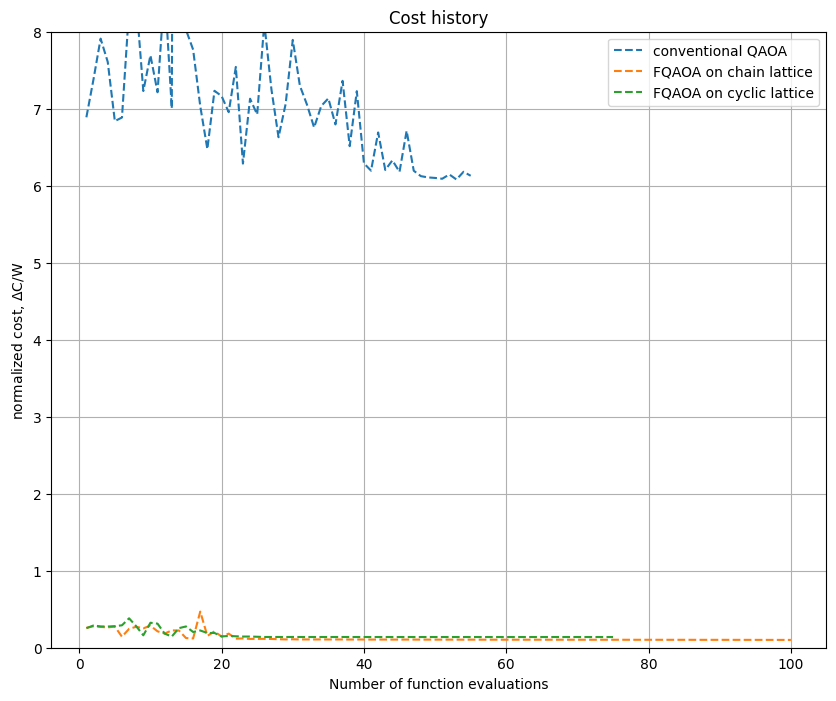

In [10]:
# plot cost history
figsize=(10, 8)
fig, ax = plt.subplots(figsize=figsize)
x3values, y3values = [], []
for i, opt_results in enumerate(opt_results_list):
    # print the cost history
    opt_results.plot_cost(ax = ax, color = f'C{i}', label = label_list[i])
ax.grid(True)    
ax.set_ylim(min_x, 2000)
ylim_scaled = 8
ax.set_ylabel(r'normalized cost, $\Delta$C/W')
ax.set_ylim(min_x, min_x+(ylim_scaled)*(max_x-min_x))
ax.set_yticks([min_x+i*(max_x-min_x) for i in range(ylim_scaled+1)], [i for i in range(ylim_scaled+1)])

plt.show()

### Performance Evaluation of FQAOA

show the best 5 states for this particular Portfolio optimization problem

In [11]:
# Print the best 5 solutions
qaoa_po_dict = opt_results_list[0].lowest_cost_bitstrings(5)
list1 = qaoa_po_dict['bitstrings_energies']
list2 = [(list1[i]-min_x)/(max_x-min_x) for i in range(5)]
qaoa_po_dict['bitstrings_energies'] = [f'{round(b, 5)} ({round(a, 5)})' for a, b in zip(list1, list2)]
qaoa_po_dict[r'$\Delta$C/W (cost)'] = qaoa_po_dict.pop('bitstrings_energies')
qaoa_po_dict[label_list[0]] = qaoa_po_dict.pop('probabilities')
for i in range(2):
    qaoa_po_dict[label_list[i+1]] = opt_results_list[i+1].lowest_cost_bitstrings(5)['probabilities']
df = pd.DataFrame(qaoa_po_dict)
print('Comparison of methods for calculating the probability of finding the optimal solutions')
display(df)

Comparison of methods for calculating the probability of finding the optimal solutions


,solutions_bitstrings,$\Delta$C/W (cost),conventional QAOA,FQAOA on chain lattice,FQAOA on cyclic lattice
0,1101100001,0.0 (-2.60427),0.000034,0.000570,0.009313
1,1101000101,0.00062 (-2.47296),0.000092,0.005923,0.018148
2,1101001001,0.00143 (-2.29972),0.000001,0.007360,0.012510
3,1100100101,0.00208 (-2.16081),0.000006,0.011066,0.004845
4,1100100011,0.00367 (-1.8207),0.000069,0.001700,0.012701


show the probability distribution of costs.

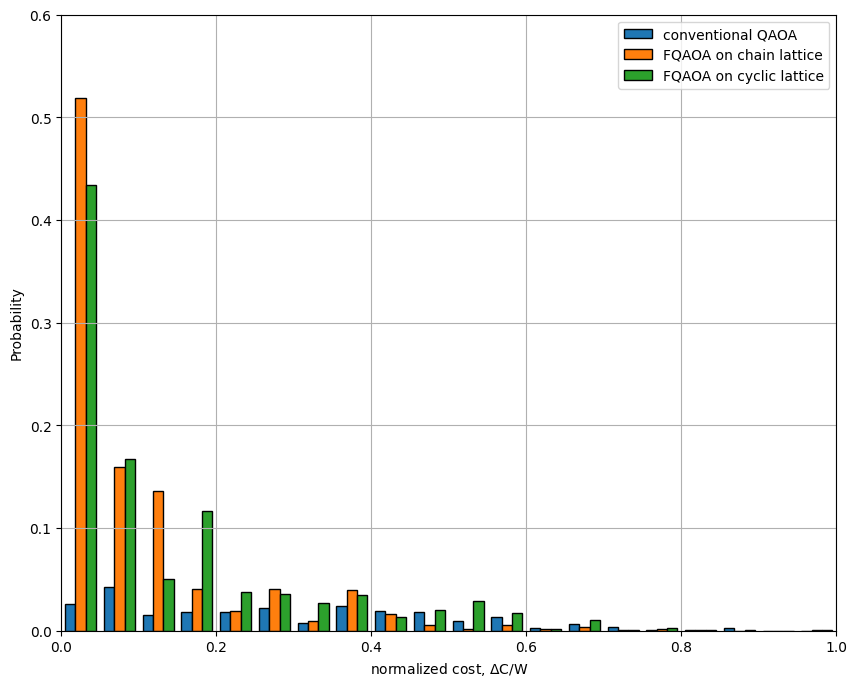

In [12]:
# plot energy distribution
for opt_results in opt_results_list:
    measurement_outcomes = opt_results.optimized['measurement_outcomes']
    costprob = []
    for i, amplitude in enumerate(measurement_outcomes):
        bit = bin(i)[2:].zfill(num_assets)
        probability = abs(amplitude)**2
        costprob.append([bitstring_energy(qaoa_po.cost_hamil, bit[::-1]), probability, bit])

    # Extracting the second values from the data points for the histogram
    xvalues = [(point[0]-min_x)/(max_x-min_x) for point in costprob]
    yvalues = [point[1] for point in costprob]

    # Plotting the histogram under constraint
    x2values, y2values = [], []
    for i in range(len(xvalues)):
        if xvalues[i] <= 1.0:
            x2values.append(xvalues[i])
            y2values.append(yvalues[i])
    x3values.append(x2values)
    y3values.append(y2values)

figsize=(10, 8)
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 0.6)
ax.hist(x3values, bins=20, weights=y3values, edgecolor='black', label = label_list)
ax.set_xlabel(r'normalized cost, $\Delta$C/W')
ax.set_ylabel('Probability')
ax.grid(True)
ax.legend()

plt.show()

# References
[1] [openqaoa/examples/community_tutorials/03_portfolio_optimization.ipynb](https://github.com/entropicalabs/openqaoa/blob/main/examples/community_tutorials/03_portfolio_optimization.ipynb) \
[2] T. Yoshioka, K. Sasada, Y. Nakano, and K. Fujii, [Phys. Rev. Research 5, 023071 (2023).](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.023071), [arXiv: 2301.10756 [quant-ph]](https://arxiv.org/pdf/2301.10756). \
[3] T. Yoshioka, K. Sasada, Y. Nakano, and K. Fujii, [2023 IEEE International Conference on Quantum Computing and Engineering (QCE) 1, 300-306 (2023).](https://ieeexplore.ieee.org/document/10313662), [arXiv: 2312.04710 [quant-phi]](https://arxiv.org/pdf/2312.04710). \
[4] Z. Jiang, J. S. Kevin, K. Kechedzhi, V. N. Smelyanskiy, and S. Boixo, [Phys. Rev. Appl. 9, 044036 (2018).](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.9.044036) \
[5] S. Hadfield, Z. Wang, B. O’Gorman, E. G. Rieffel, D. Venturelli, and R. Biswas, [algorithms 12, 34 (2019).](https://www.mdpi.com/1999-4893/12/2/34) \
[6] Z. Wang, N. C. Rubin, J. M. Dominy, and E. G. Rioeffel, [Phys. Rev. A 101, 012320 (2020).](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012320)